Stephanie Chiang
DATA 620 Summer 2025
Final Project
# Last Words
### An Analysis of the Final Statements of Death Row Inmates Using Natural Language Processing

### Introduction

This project aims to examine the “last words” of death row inmates by using their official final statements, as published on the [Texas Department of Criminal Justice website](https://www.tdcj.texas.gov/death_row/dr_executed_offenders.html).

My interest is in trying to understand what people facing the end of their lives think and feel. This type of data is almost impossible (and perhaps ethically dubious) to collect systematically from the general population. However, inmates in Texas facing execution are given the chance to make final statements, which have been collected since at least 1982. I plan to use this publicly available data to explore the language of last statements for any patterns which may reveal insights into emotional states and common themes. And I aim to do so with sensitivity and respect for the individuals involved.

Using NLP, I goal is to be able to illuminate what people feel, think and value when death is imminent. This is a universal human experience and my hope that this information would be helpful to any others facing the same; in effect, this is all of us, just on different time scales.

### Data Collection

The data is collected from the Texas Department of Criminal Justice website, which provides a list of death row inmates and their last statements. The scraping process involves:
1. Fetching the main page containing individual inmate data and links to last statement pages.
2. Extracting the URL of each inmate's page.
3. Visiting each link to scrape the inmate's last statement.
4. Storing the data in a structured format for analysis.

I will use the Beautiful Soup library to parse the HTML and extract the relevant information. The final dataset will include the inmate's name, last statement, and some demographic details.

In [27]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Step 1: Get the main page table and parse
base_url = "https://www.tdcj.texas.gov"
table_url = urljoin(base_url, "/death_row/dr_executed_offenders.html")

response = requests.get(table_url, verify=False)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

# Step 2: Extract the links from the 3rd column and other relevant data
links = []

for row in soup.find_all("tr"):
    cells = row.find_all("td")
    if cells:
        id = cells[0].get_text(strip=True)
        last_name = cells[3].get_text(strip=True)
        first_name = cells[4].get_text(strip=True)
        age = cells[6].get_text(strip=True)
        date = cells[7].get_text(strip=True)
        race = cells[8].get_text(strip=True)

        link_tag = cells[2].find("a")
        slug = link_tag.get("href")

        # Skip rows with no last statement
        if "no_last_statement" in slug:
            continue
        # Ensure slugs are correctly formatted
        if slug and not slug.startswith("/death_row/"):
            slug = "/death_row/" + slug
        # Construct a row in the draft data
        if link_tag and slug:
            href = urljoin(base_url, slug)
            links.append([id, last_name, first_name, age, date, race, href])

print(f"Found {len(links)} links.")

Found 493 links.


In [28]:
# Step 3: Visit each link, parse and scrape data
scraped_data = []

for row in links:
    url = row[-1]
    try:
        page_response = requests.get(url, verify=False)
        page_response.raise_for_status()
        page_soup = BeautifulSoup(page_response.text, "html.parser")

        statement = page_soup.find_all("p")[5].get_text(strip=True) if page_soup.find("p") else "NA"
        scraped_data.append(row + [statement])
    except Exception as e:
        print(f"Failed to scrape {url}: {e}")

print(f"Scraped {len(scraped_data)} rows.")

Failed to scrape https://www.tdcj.texas.gov/death_row/dr_info/bibledannylast.html: list index out of range
Scraped 492 rows.


The above scraping took about 2 minutes and resulted in 1 error, due to a page layout issue. A quick check confirms there is no recorded statement for this person, so we can proceed without this row.

Below, the data is recorded as a CSV before proceeding to analysis.

In [80]:
import csv

csv_filename = "dr_scraped.csv"

with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["id", "last_name", "first_name", "age", "date", "race", "url", "statement"])
    writer.writerows(scraped_data)

print(f"Saved to '{csv_filename}'")

Saved to 'dr_scraped.csv'


### Exploratory Data Analysis & Visualization

First, we will prepare the data so that some of the demographic details can be visualized. I want to paint the fullest possible picture of the people whose statements are being examined.

In [69]:
import pandas as pd

# Convert to pandas dataframe for analysis
dr_df = pd.DataFrame(scraped_data, columns=["id", "last_name", "first_name", "age", "date", "race", "url", "statement"])

# Convert 'id' and 'age' to integer
dr_df['id'] = pd.to_numeric(dr_df['id'], errors='coerce')
dr_df['age'] = pd.to_numeric(dr_df['age'], errors='coerce')

# Convert 'race' to categorical and check levels
dr_df['race'] = dr_df['race'].astype('category')
print(dr_df['race'].cat.categories.tolist())

# Convert 'date' to datetime
dr_df['date'] = pd.to_datetime(dr_df['date'], errors='coerce')

print(dr_df.info())

['Black', 'Hispanic', 'Other', 'White']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          492 non-null    int64         
 1   last_name   492 non-null    object        
 2   first_name  492 non-null    object        
 3   age         492 non-null    int64         
 4   date        492 non-null    datetime64[ns]
 5   race        492 non-null    category      
 6   url         492 non-null    object        
 7   statement   492 non-null    object        
dtypes: category(1), datetime64[ns](1), int64(2), object(4)
memory usage: 27.7+ KB
None


In [70]:
# Drop rows with missing statements
missing1 = dr_df[dr_df['statement'].str.contains("no last statement|no statement", case=False, na=False)].index
dr_df = dr_df.drop(missing1)

missing2 = dr_df[dr_df['statement'] == "None"].index
dr_df = dr_df.drop(missing2)

missing3 = dr_df[dr_df['statement'] == "None."].index
dr_df = dr_df.drop(missing3)

print(dr_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 484 entries, 0 to 491
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          484 non-null    int64         
 1   last_name   484 non-null    object        
 2   first_name  484 non-null    object        
 3   age         484 non-null    int64         
 4   date        484 non-null    datetime64[ns]
 5   race        484 non-null    category      
 6   url         484 non-null    object        
 7   statement   484 non-null    object        
dtypes: category(1), datetime64[ns](1), int64(2), object(4)
memory usage: 30.9+ KB
None


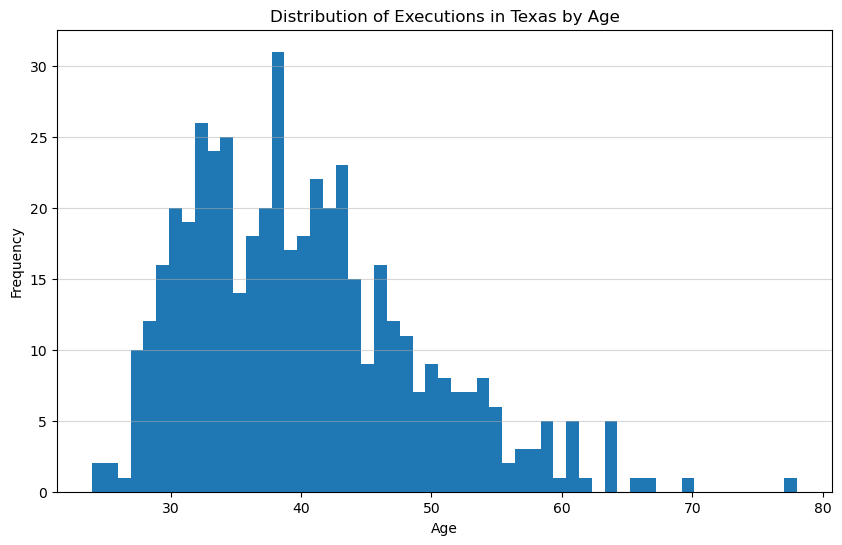

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dr_df['age'], bins=55)
plt.title('Distribution of Executions in Texas by Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

The age histogram shows that most of the executed inmates were around 30 to the mid-40s, with a large spike at just under the age of 40. This dispiriting statistic skews younger than I had expected. 

In regards to our analysis, this indicates that the statements have mostly come from people who were not otherwise expecting to be close the end of their lives. It's possible they would not have yet confronted the concept of death if not for their incarceration.

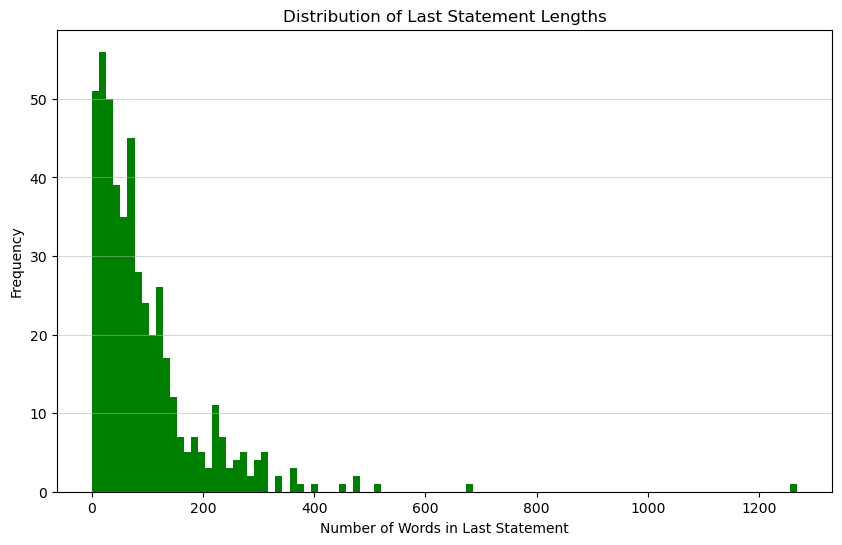

In [138]:
dr_df['statement_length'] = dr_df['statement'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(dr_df['statement_length'], bins=100, color='green')
plt.title('Distribution of Last Statement Lengths')
plt.xlabel('Number of Words in Last Statement')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

We can also see that a large majority of collected statements were on the shorter side, with only a couple outliers over 600 words. Though this does not yet give full insight into the content of those statements, this could point to a more limited variety of chosen words.

### Natural Language Processing

I will use the NLTK library to perform language processing and sentiment analysis.

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Combine all statements into one large string and tokenize
all_text = " ".join(dr_df["statement"].tolist())
tokens = word_tokenize(all_text)

# Convert to lowercase, remove non-alphabetic words and stop words (e.g., 'the', 'is', 'and', etc.)
words = [word.lower() for word in tokens if word.isalpha()]
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word not in stop_words]

# Unique words
unique_words = set(filtered_words)
print(len(unique_words))

# Word frequencies
word_freq = Counter(filtered_words)

# Most common words
print("Top 10 words:")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")

3053
Top 10 words:
love: 752
family: 359
know: 343
thank: 327
sorry: 281
want: 260
would: 255
like: 239
god: 237
say: 182


[('love', 752), ('family', 359), ('know', 343), ('thank', 327), ('sorry', 281), ('want', 260), ('would', 255), ('like', 239), ('god', 237), ('say', 182), ('life', 174), ('hope', 164), ('forgive', 163), ('lord', 154), ('going', 144), ('tell', 133), ('yes', 132), ('one', 129), ('peace', 129), ('people', 126), ('ya', 122), ('warden', 121), ('take', 119), ('see', 118), ('jesus', 110), ('give', 100), ('ready', 100), ('done', 99), ('pain', 98), ('keep', 97), ('ask', 93), ('go', 90), ('death', 87), ('strong', 85), ('heart', 85), ('let', 85), ('man', 84), ('father', 82), ('get', 80), ('friends', 80), ('everybody', 80), ('years', 77), ('pray', 74), ('right', 74), ('find', 74), ('us', 72), ('back', 70), ('caused', 69), ('time', 68), ('never', 67), ('could', 66), ('come', 65), ('please', 63), ('home', 62), ('forgiveness', 61), ('stay', 61), ('care', 61), ('got', 60), ('make', 60), ('everyone', 60), ('good', 60), ('day', 59), ('apologize', 59), ('always', 58), ('first', 57), ('mom', 57), ('loved',

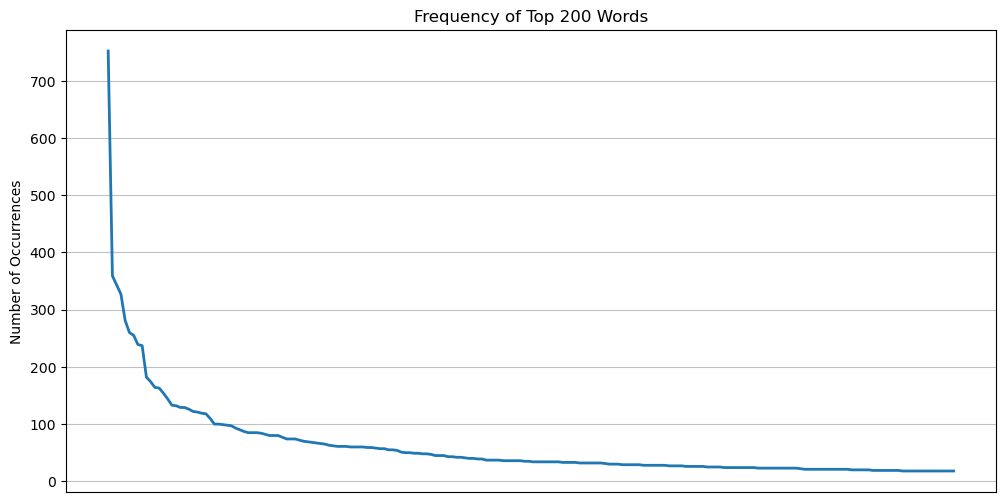

In [113]:
from nltk.probability import FreqDist

fdist = FreqDist(filtered_words)
top_200 = fdist.most_common(200)
print(top_200)

plt.figure(figsize=(12, 6))
fdist.plot(200, cumulative=False)
plt.title('Frequency of Top 200 Words')
plt.xticks([])
plt.xlabel('')
plt.ylabel('Number of Occurrences')
plt.show()

Zipf's law describes the phenomenon in natural language in which word frequency, when sorted in decreasing order, is inversely proportional to its rank. Basically, the nth word has a frequency proportional to 1/n. 
This is consistent with Zipf's law.


In [116]:
def clean_tokenize(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

dr_df["tokens"] = dr_df["statement"].apply(clean_tokenize)

# Get top N frequent words
all_words = [word for tokens in dr_df["tokens"] for word in tokens]
word_freq = nltk.FreqDist(all_words)
top_n = 5
top_words = set([word for word, _ in word_freq.most_common(top_n)])

# Step 3: Select top N most frequent words
top_n = 200
top_words = set([word for word, freq in word_freq.most_common(top_n)])

print(f"Top {top_n} words: {top_words}")


edges = []
for _, row in dr_df.iterrows():
    for word in row["tokens"]:
        if word in top_words:
            edges.append({
                "id": row["id"],
                "age": row["age"],
                "race": row["race"],
                "word": word
            })

# Convert to DataFrame
edgelist_df = pd.DataFrame(edges, columns=["id", "word"])
print("\nBipartite Edgelist:")
print(edgelist_df)

edgelist_df.to_csv("bipartite_edgelist.csv", index=False)

Top 200 words: {'last', 'wish', 'victim', 'got', 'thy', 'anything', 'everything', 'look', 'soul', 'na', 'justice', 'mercy', 'please', 'hate', 'spirit', 'alright', 'continue', 'fight', 'make', 'talk', 'said', 'also', 'part', 'john', 'closure', 'thing', 'bring', 'father', 'like', 'hurt', 'kill', 'remember', 'us', 'stay', 'mom', 'sir', 'would', 'sister', 'change', 'today', 'innocent', 'years', 'words', 'ones', 'christ', 'jesus', 'right', 'truth', 'dad', 'real', 'must', 'hope', 'shall', 'long', 'thank', 'goodbye', 'see', 'way', 'say', 'loved', 'man', 'going', 'lot', 'helped', 'bad', 'tonight', 'care', 'irene', 'come', 'strength', 'things', 'god', 'allah', 'ask', 'life', 'much', 'ca', 'kids', 'else', 'ah', 'okay', 'first', 'truly', 'family', 'row', 'letter', 'told', 'could', 'even', 'think', 'caused', 'world', 'forgiveness', 'get', 'may', 'one', 'apologize', 'nothing', 'everybody', 'stop', 'mean', 'understand', 'better', 'take', 'ya', 'side', 'bless', 'together', 'thanks', 'love', 'time', '

In [117]:
import networkx as nx

B = nx.Graph()

# Add row_id nodes with metadata
for _, row in dr_df.iterrows():
    B.add_node(
        row["id"], 
        bipartite=0,  # Set type: 0 = person node
        label=row["id"],
        race=row["race"],
        age=row["age"],
        node_type="person"
    )

# Add word nodes
for word in top_words:
    B.add_node(
        word, 
        bipartite=1,  # Set type: 1 = word node
        label=word,
        node_type="word"
    )

# Add edges (row_id <-> word)
for _, row in dr_df.iterrows():
    for word in row["tokens"]:
        if word in top_words:
            B.add_edge(row["id"], word)

print(f"\nGraph summary: {B.number_of_nodes()} nodes, {B.number_of_edges()} edges.")


Graph summary: 684 nodes, 8405 edges.



Co-occurrence network: 200 nodes, 17829 edges.


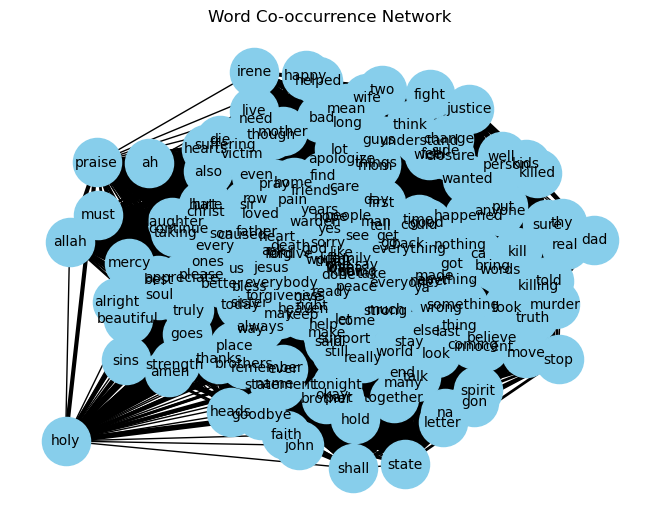

In [118]:
from itertools import combinations

# --- Build word co-occurrence network ---
G = nx.Graph()

# Add word nodes
for word in top_words:
    G.add_node(word, label=word)

# For each paragraph, find co-occurring pairs of top words
for tokens in dr_df["tokens"]:
    # Filter tokens to only top words
    filtered = [word for word in tokens if word in top_words]
    # Add edges for all pairs of co-occurring words
    for word1, word2 in combinations(set(filtered), 2):
        if G.has_edge(word1, word2):
            G[word1][word2]["weight"] += 1
        else:
            G.add_edge(word1, word2, weight=1)

print(f"\nCo-occurrence network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

pos = nx.spring_layout(G, seed=42)
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]

nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=1200, font_size=10, width=edge_weights)
plt.title("Word Co-occurrence Network")
plt.show()